In [81]:
import numpy as np
import scipy as sp
import graph_cut
from skimage import io, color
import matplotlib.pyplot as plt
import time 
from generate_data import generate_data
from utils import collage

%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
def show(M, title='', name='', path='Images/', save=False):
    plt.imshow(M)
    plt.title(title, size=18)
    plt.yticks([])
    plt.xticks([])
    if save:
        plt.savefig("data/"+title+'.png')

In [86]:
def alpha_expantion_routine(psi1, psi2V, psi2H, metric, maxIter=500):
    N, M, K = psi1.shape
    current_labels = np.random.randint(0, K, size=(N, M))
    bigNumber = 1e30
    energy = np.array([])
   
    curLabel = 0
    for iter_ in range(maxIter):
        curLabel = (curLabel + 1) % K
        psi1_up = psi1.reshape(N * M, K)[np.arange(N * M), current_labels.ravel()].reshape(N, M)
        psi1_up[current_labels == curLabel] = bigNumber
       
        psi1_down = psi1.reshape(N * M, K)[np.arange(N * M), curLabel].reshape(N, M)
       
        ### Vertical potentials
       
        phi_00_vert = psi2V.ravel() * metric[current_labels[:-1, :].ravel(), current_labels[1:, :].ravel()]
        phi_01_vert = psi2V.ravel() * metric[current_labels[:-1, :].ravel(), curLabel]
        phi_10_vert = psi2V.ravel() * metric[curLabel, current_labels[1:, :].ravel()]
       
        # psi1_down[:-1, :] += phi_00_vert.reshape((N - 1, M))
        psi1_up[:-1, :] += (phi_01_vert - phi_10_vert + phi_00_vert).reshape((N - 1, M)) / 2
        psi1_up[1:, :] += (phi_01_vert - phi_10_vert + phi_00_vert).reshape((N - 1, M)) / 2
       
        phi_01_vert = (phi_01_vert + phi_10_vert - phi_00_vert) / 2
       
        # Gorizontal potentials

        phi_00_hor = psi2H.ravel() * metric[current_labels[:, :-1].ravel(), current_labels[:, 1:].ravel()]
        phi_01_hor = psi2H.ravel() * metric[current_labels[:, :-1].ravel(), curLabel]
        phi_10_hor = psi2H.ravel() * metric[curLabel, current_labels[:, 1:].ravel()]
       
        psi1_up[:, :-1] += (phi_01_hor - phi_10_hor + phi_00_hor).reshape((N, M - 1)) / 2
        psi1_up[:, 1:] += (phi_01_hor - phi_10_hor + phi_00_hor).reshape((N, M - 1)) / 2
       
        phi_01_hor = (phi_01_hor + phi_10_hor - phi_00_hor) / 2
       
        ###
       
        term_weights = np.vstack((psi1_up.ravel(), psi1_down.ravel()))
       
       
        vert_weights = np.vstack((np.arange((N - 1) * M), M + np.arange((N - 1) * M), phi_01_vert, phi_01_vert))
        hor_weights = np.vstack((np.arange(N * M).reshape((N, M))[:, :-1].ravel(),
                                 np.arange(N * M).reshape((N, M))[:, 1:].ravel(), phi_01_hor, phi_01_hor))                        
       
        edge_weights = np.hstack((vert_weights, hor_weights))
       
        # print((edge_weights >= 0).all(), np.min(term_weights))
       
        cut, labels = graph_cut.graph_cut(term_weights.T, edge_weights.T)
        labels = labels.reshape((N, M))
        current_labels[labels == 0] = curLabel
        energy = np.append(energy, cut)    
        plt.imshow(current_labels, cmap="Greys_r")
        plt.show()
       
    return current_labels.ravel(), energy

In [87]:
images = np.load("Images/2photo/images.npy")
seeds = np.load("Images/2photo/masks.npy")

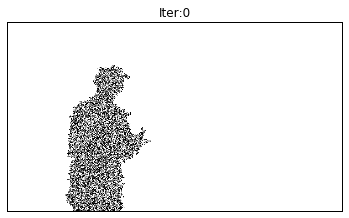

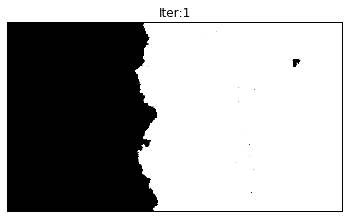

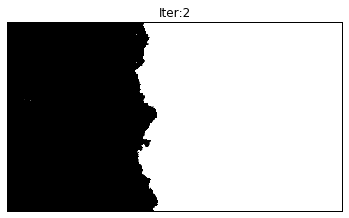

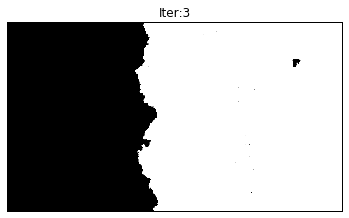

In [176]:
image, mask = collage(images, seeds)

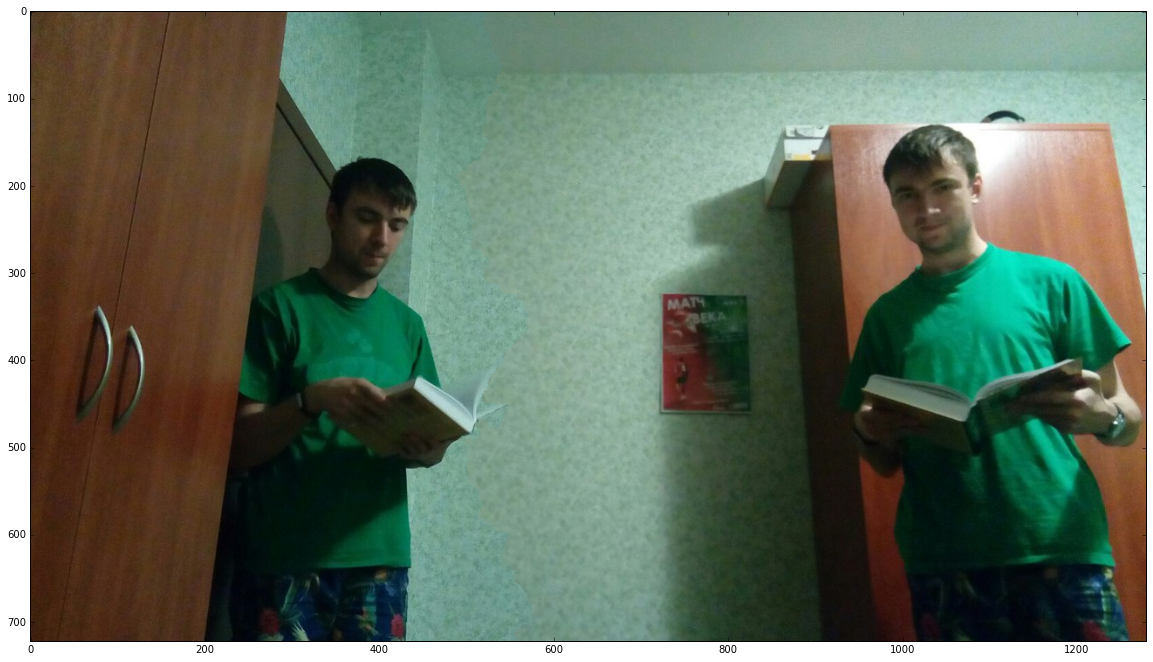

In [177]:
plt.figure(figsize=(20, 12))

plt.imshow(image)
#plt.savefig("optimal2.png")
plt.show()

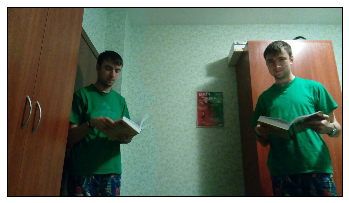

In [74]:
show(image)

In [48]:
imagesPaths = ['left.jpg', 'right.jpg']
masksPaths = ['leftMask.jpg', 'rightMask.jpg']
masksPaths = ['Images/2photo/'+p for p in masksPaths]
imagesPaths = ['Images/2photo/'+p for p in imagesPaths]

In [56]:
generate_data(imagesPaths, masksPaths,'Images/2photo/')

In [114]:
K = 3
M = 2 
N = 2
a = np.random.randint(0, K, size=(N, M))

In [138]:
a = np.array([1,2 ,3 ,4])
a

array([1, 2, 3, 4])

In [139]:
a[[1,1,1]] += 1

In [140]:
a

array([1, 3, 3, 4])

In [150]:
vert01.shape

(922880,)

In [152]:
vert_weights.shape

(4, 922880)

In [161]:
n = 2
m = 3
a = np.arange(n * m).reshape((n, m))[:, :-1].ravel()

In [162]:
a

array([0, 1, 3, 4])

In [ ]:

psi1 = np.zeros((n, m, k))
for i, mask in enumerate(masks):
    psi1[mask, :] = np.inf
    psi1[mask, i] = 0